In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.callbacks import ProgbarLogger


In [5]:
# df = pd.read_csv(r'D:\xuhu\Temp\dataset_150_manual_clean.csv')
df = pd.read_csv(r'D:\xuhu\pyansys-heart\downloads\Strocchi2020\01\Biv_dataset\dataset_40_220.csv')

print(df.head())

                                              LeadII    sigmaX    ratio2
0  [ 3.18085560e-03  1.44712092e-03  1.29275136e-...  1.180131  5.522553
1  [ 1.94027305e-03  8.81275820e-04  9.05450270e-...  0.886647  6.813840
2  [ 4.40902250e-03  1.97902389e-03  1.65635571e-...  1.470678  7.802587
3  [ 2.44415151e-03  1.11904018e-03  1.06973749e-...  1.005849  7.151262
4  [ 6.59697570e-04  2.33656858e-04  4.50549800e-...  0.583702  1.897641


## Learning Phase(not inverse problem)

In [12]:
# # input
# X = df['LeadII'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))
# X = np.stack(X, axis=0)

# # output: paramaters to predict
# Y = df[['sigmaX', 'ratio2']].values

# output: ECGs to predict
Y = df['LeadII'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))
Y = np.stack(Y, axis=0)

# input
X = df[['sigmaX', 'ratio2']].values

In [19]:
X.shape

(129, 2)

In [20]:
Y.shape

(129, 799)

In [8]:
from matplotlib.ticker import AutoMinorLocator
from math import ceil 
import matplotlib.pyplot as plt

def _ax_plot(ax, x, y, secs=10, lwidth=0.5, amplitude_ecg=1.4, time_ticks=0.2):
    ax.set_xticks(np.arange(0, 11, time_ticks))    
    ax.set_yticks(np.arange(-ceil(amplitude_ecg), ceil(amplitude_ecg), 1.0))
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.set_ylim(-amplitude_ecg, amplitude_ecg)
    ax.set_xlim(0, secs)
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
    ax.grid(which='minor', linestyle='-', linewidth='0.5', color=(1, 0.7, 0.7))
    ax.plot(x, y, linewidth=lwidth)



def plot_1(ecg, sigma_x, ratio_2, index, sample_rate=500, title='ECG', fig_width=6, fig_height=2, line_w=1, ecg_amp=1.8, timetick=0.2, save_path=None):
    """Plot multi lead ECG chart.
    # Arguments
        ecg        : m x n ECG signal data, which m is number of leads and n is length of signal.
        sample_rate: Sample rate of the signal.
        title      : Title which will be shown on top off chart
        fig_width  : The width of the plot
        fig_height : The height of the plot
    """
    plt.figure(figsize=(fig_width,fig_height))
    plt.suptitle(f'Lead II ECG {index + 1} - sigmaX: {sigma_x}, ratio2: {ratio_2}')
    plt.subplots_adjust(
        hspace = 0, 
        wspace = 0.04,
        left   = 0.04,  # the left side of the subplots of the figure
        right  = 0.98,  # the right side of the subplots of the figure
        bottom = 0.2,   # the bottom of the subplots of the figure
        top    = 0.88
        )
    seconds = len(ecg)/sample_rate

    ax = plt.subplot(1, 1, 1)
    #plt.rcParams['lines.linewidth'] = 5
    step = 1.0/sample_rate
    _ax_plot(ax,np.arange(0,len(ecg)*step,step),ecg, seconds, line_w, ecg_amp,timetick)


C:\Users\xuhu\AppData\Local\Temp\ipykernel_286636\3903332744.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(fig_width,fig_height))


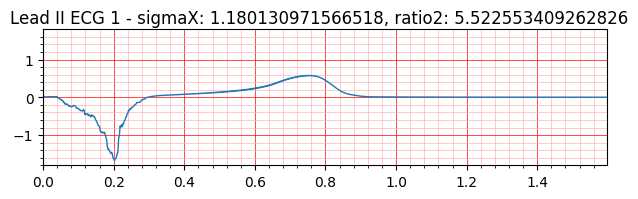

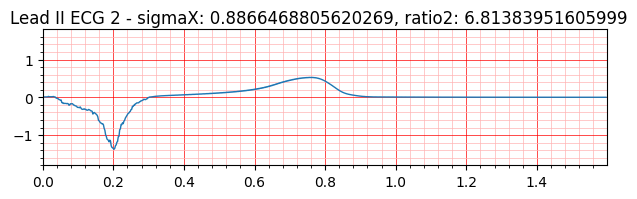

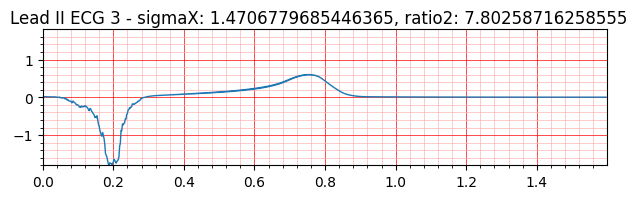

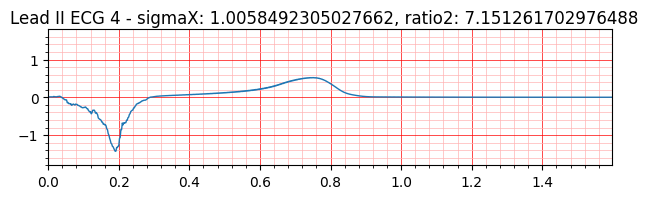

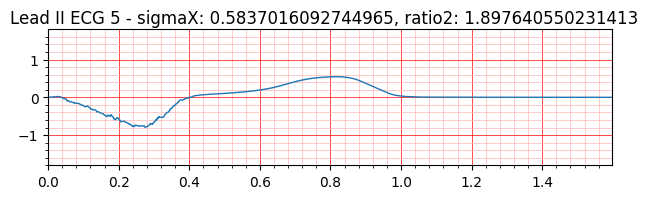

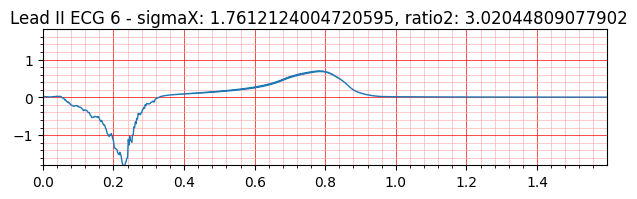

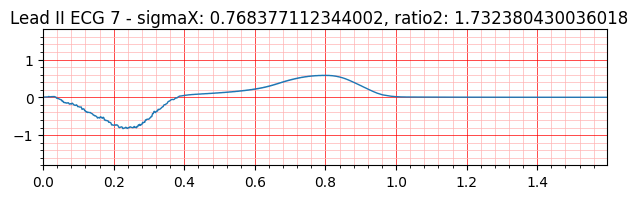

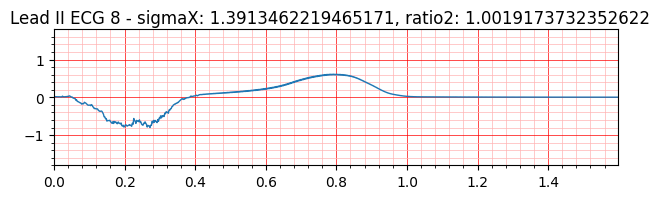

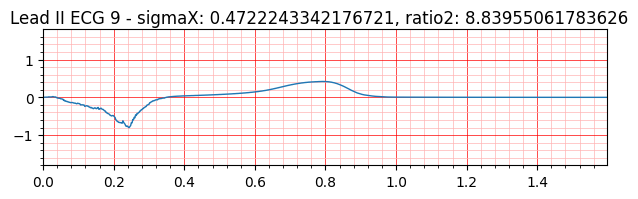

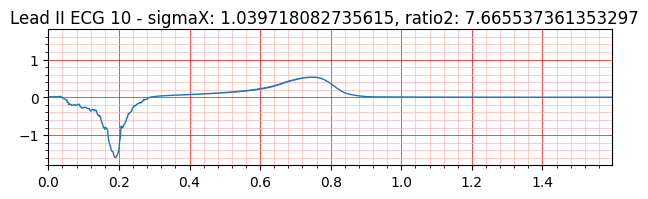

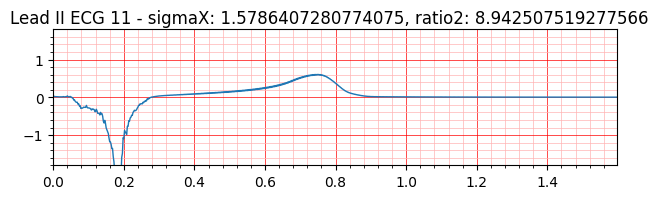

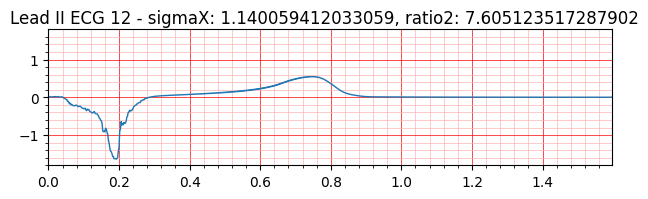

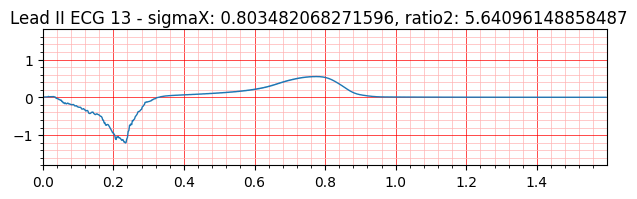

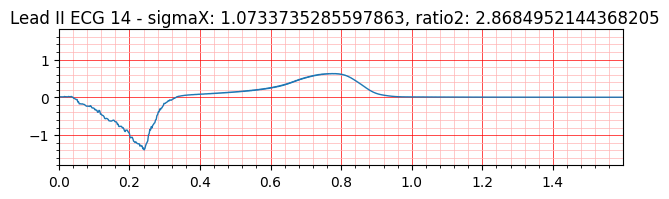

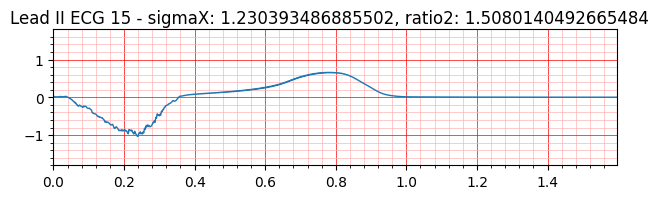

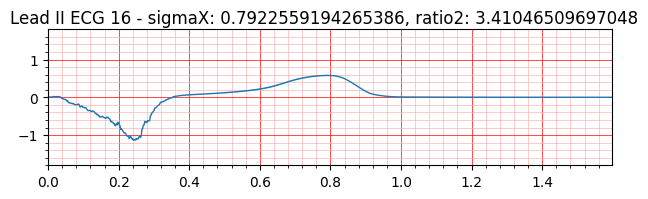

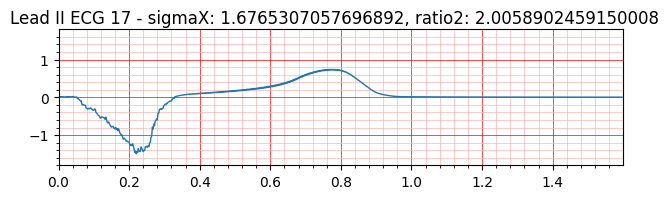

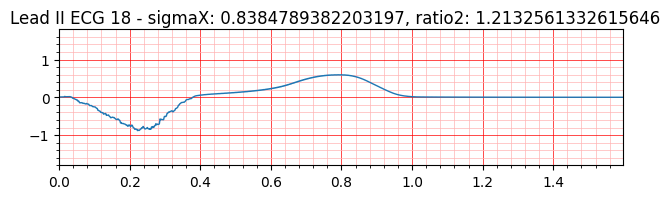

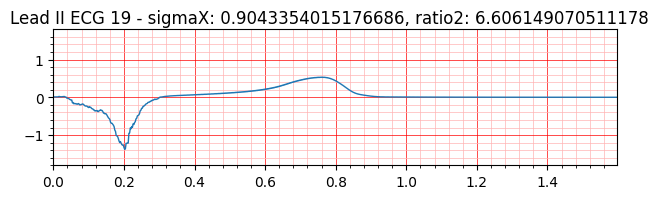

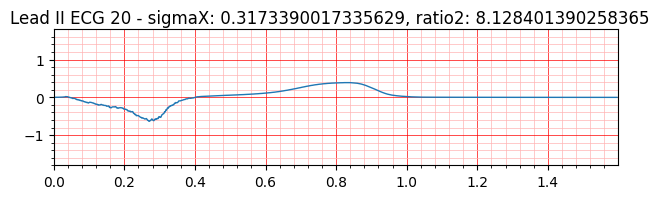

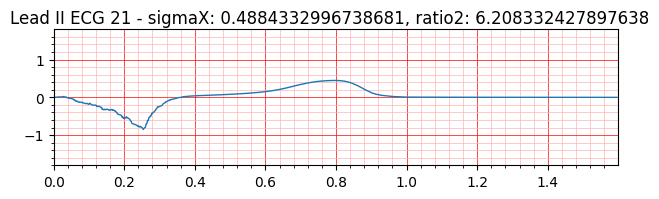

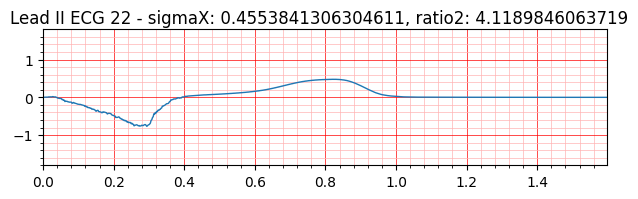

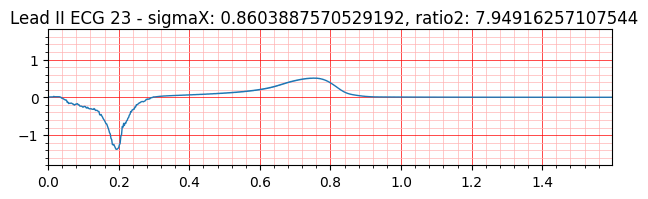

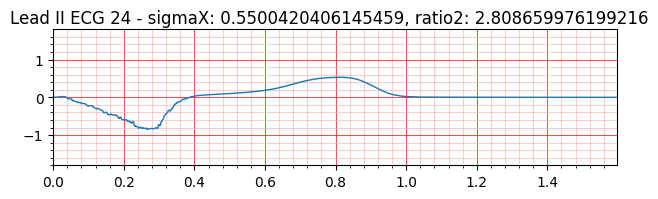

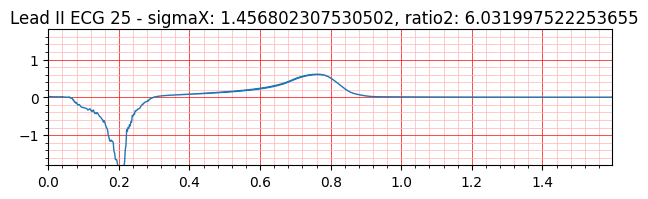

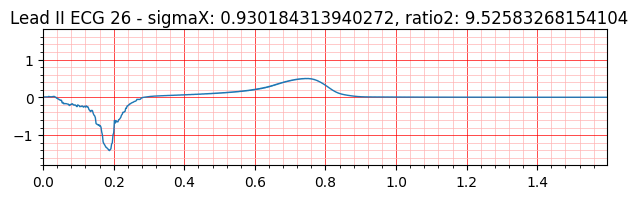

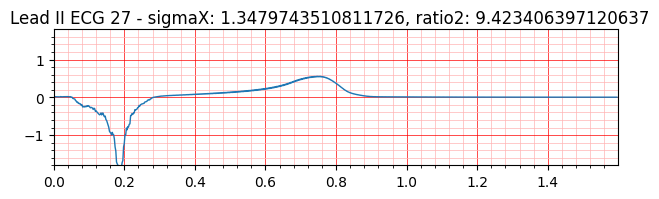

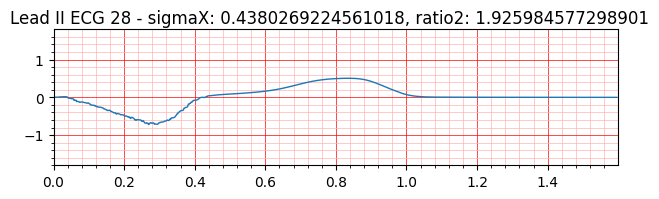

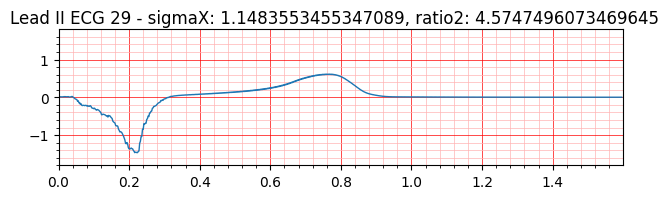

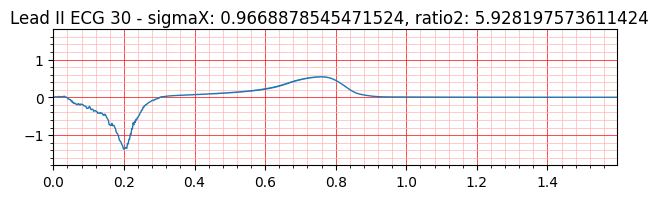

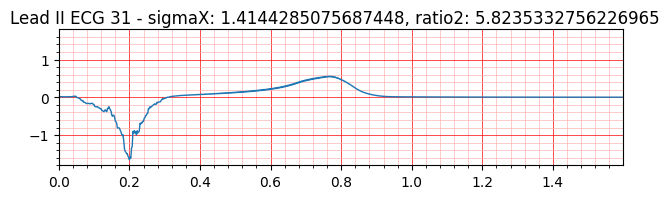

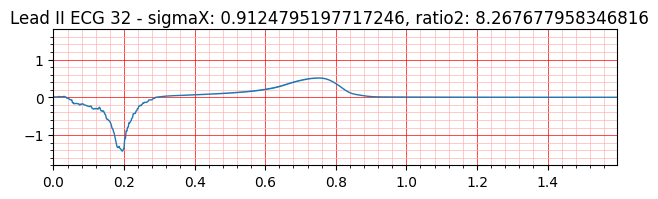

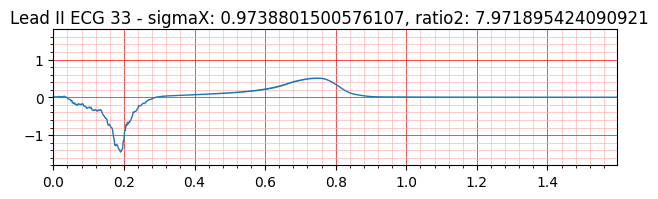

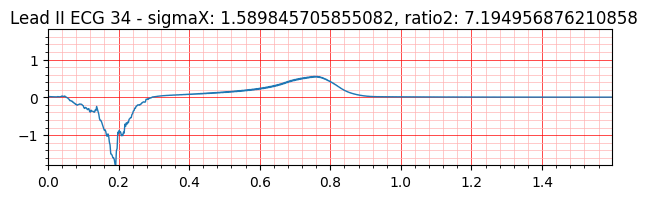

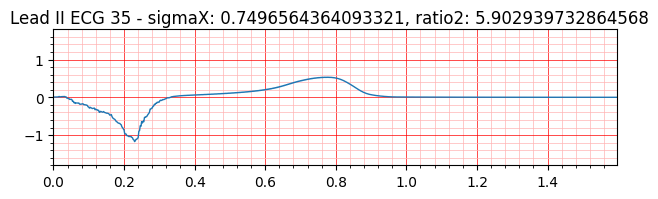

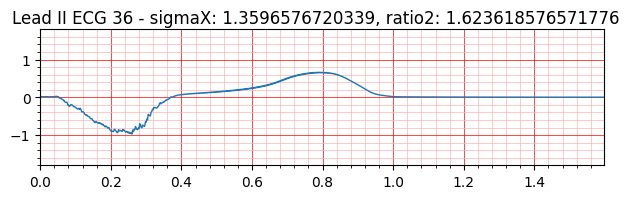

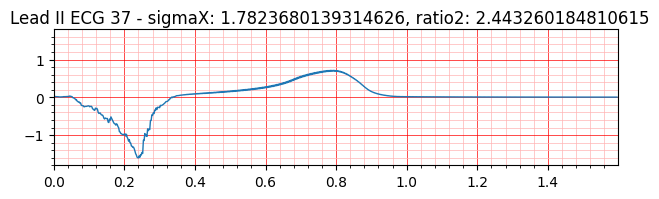

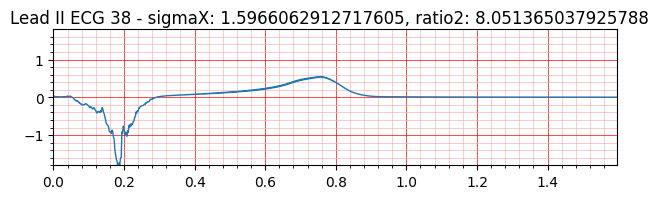

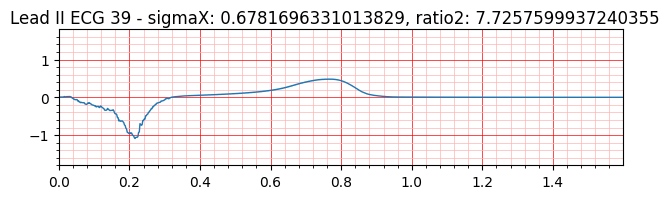

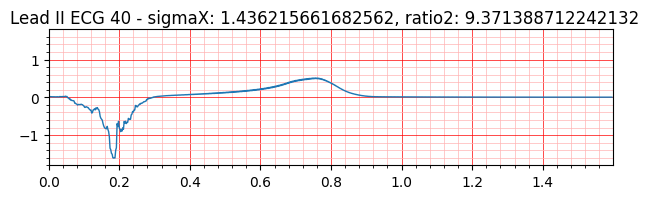

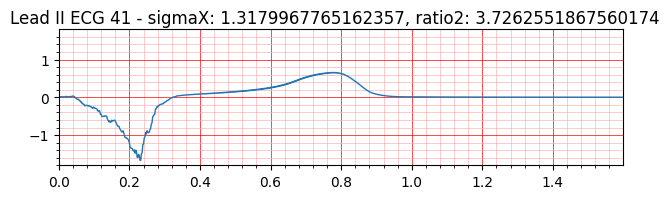

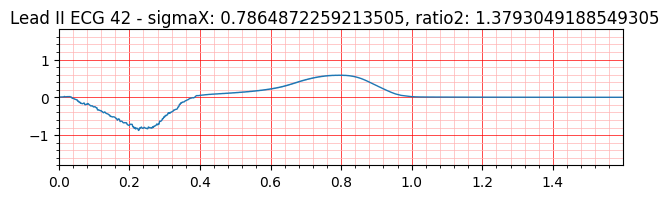

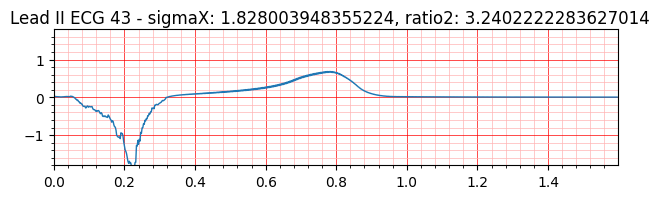

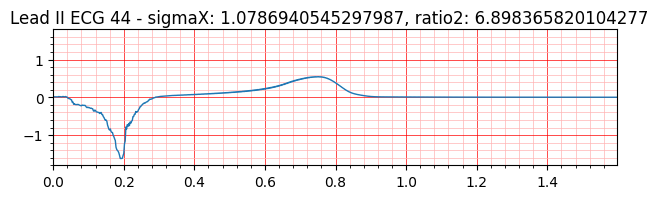

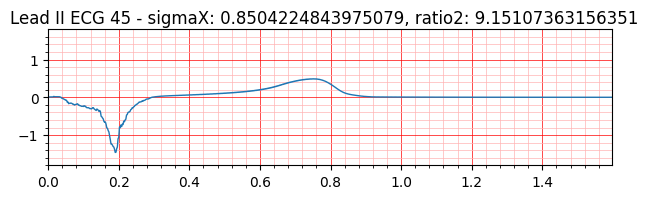

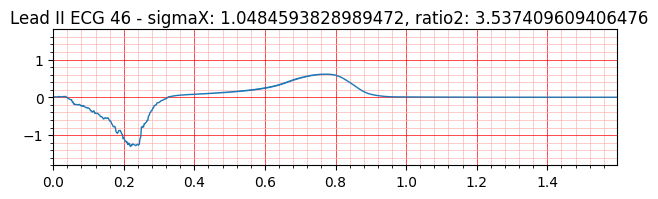

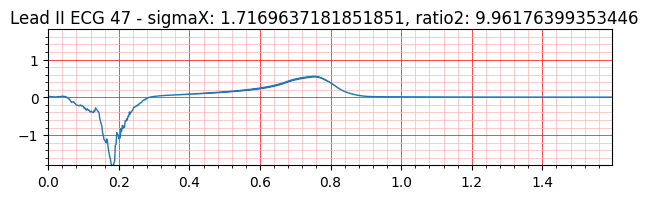

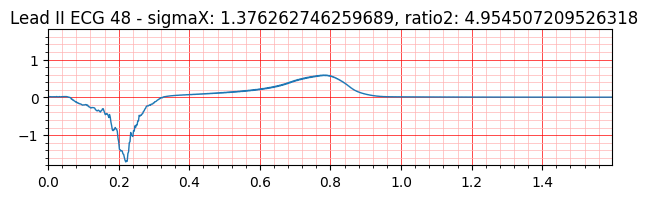

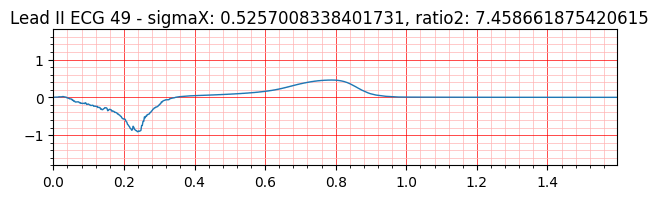

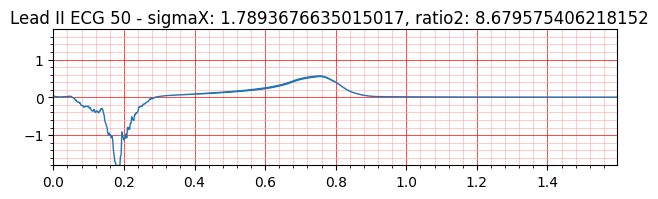

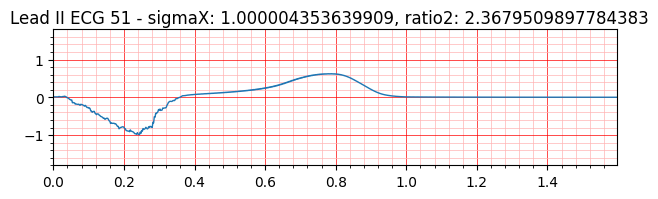

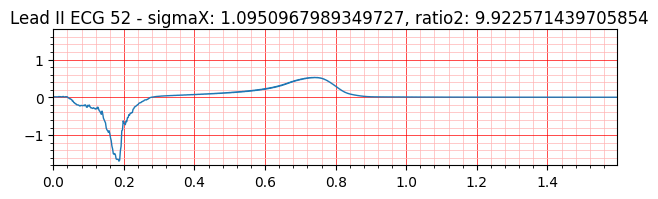

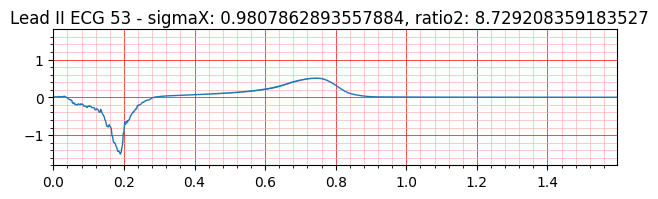

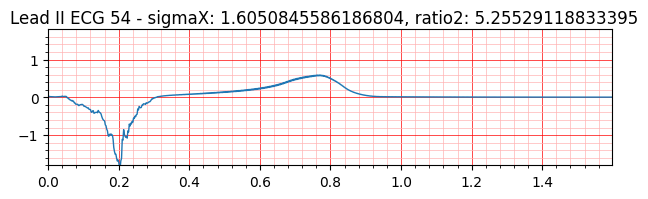

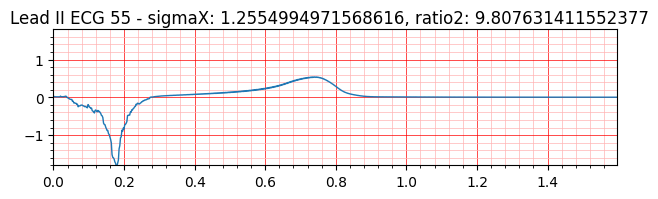

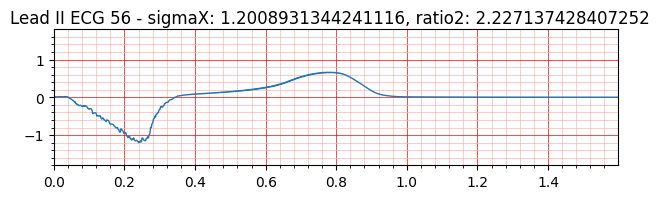

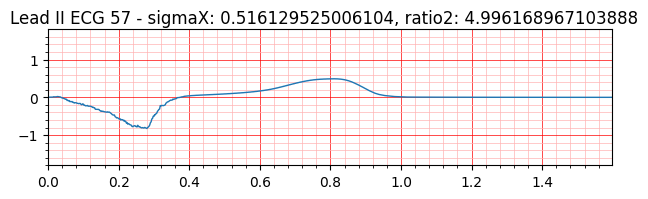

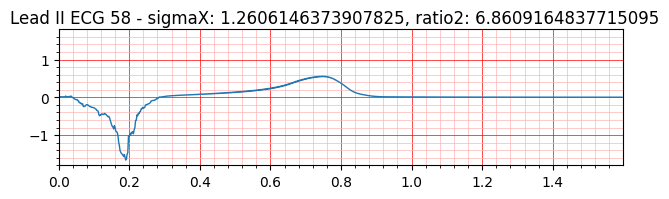

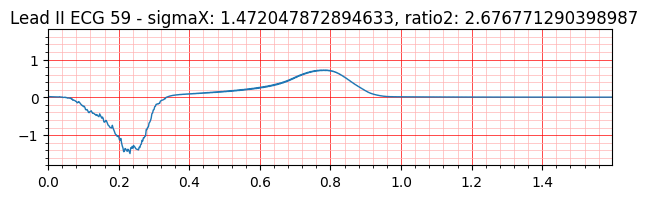

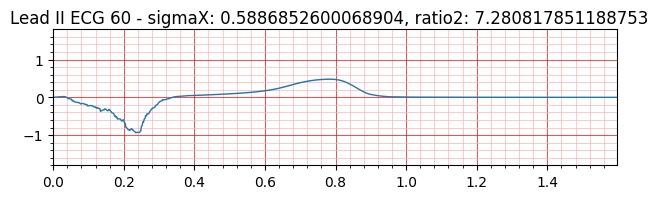

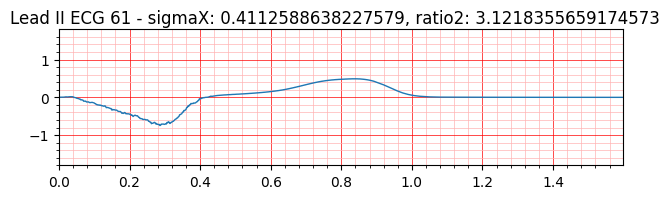

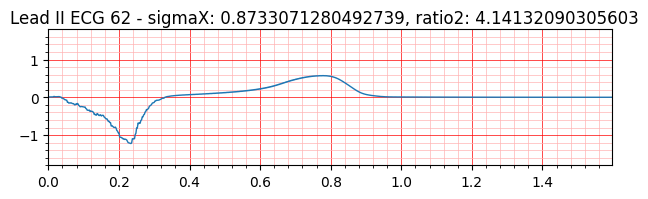

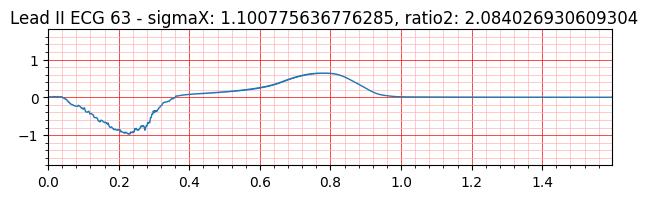

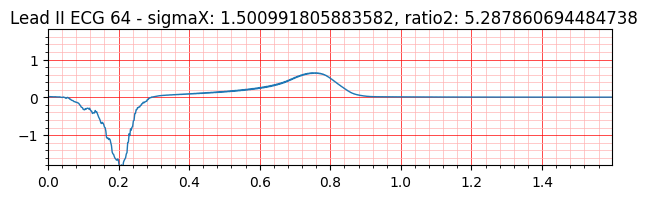

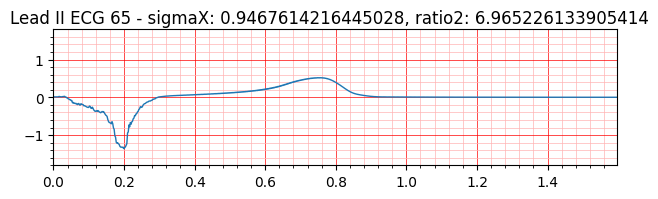

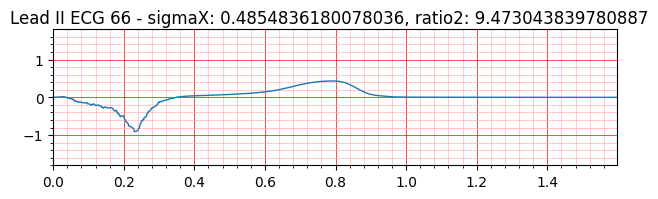

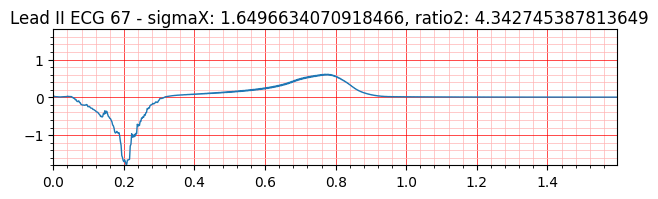

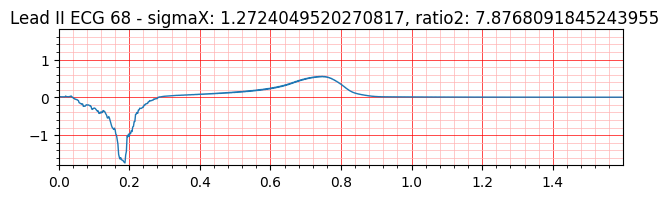

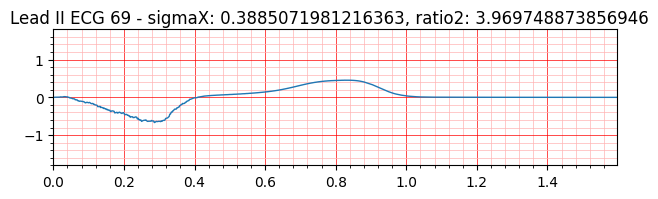

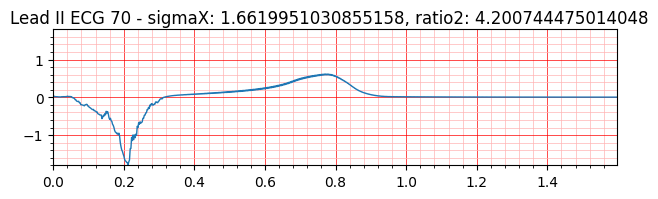

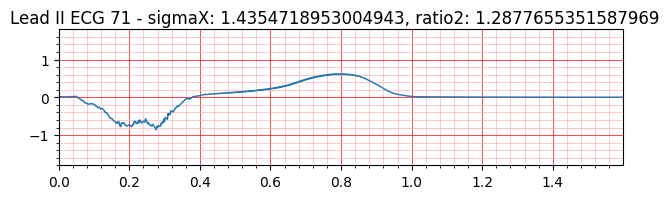

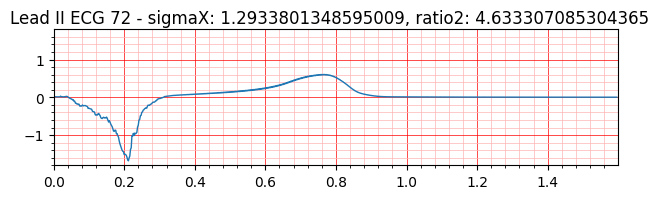

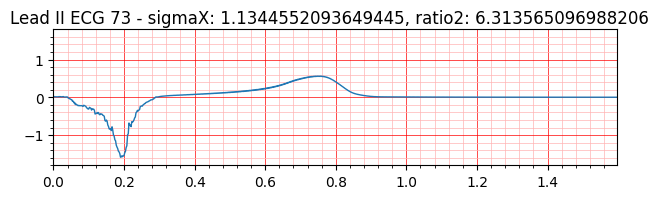

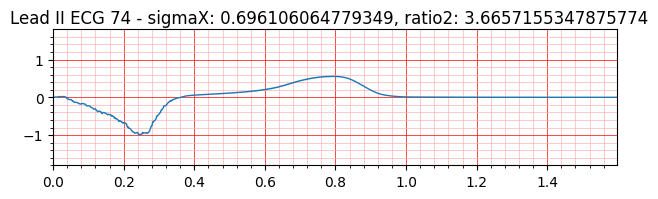

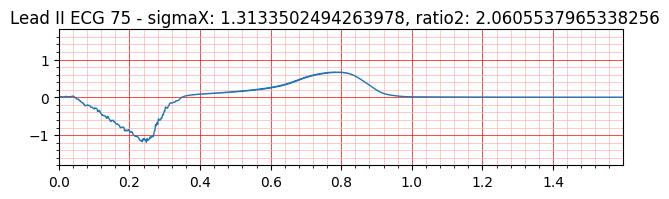

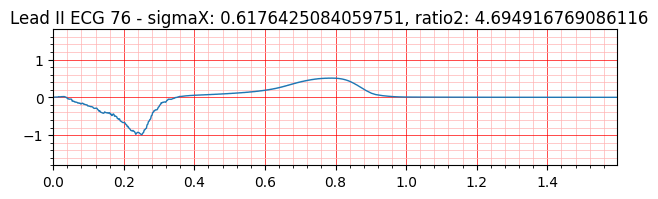

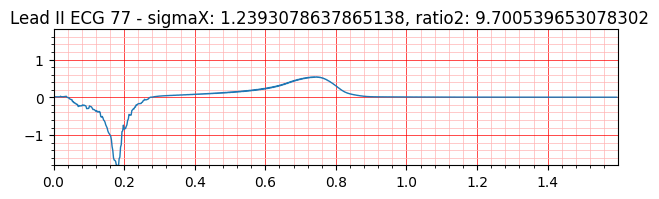

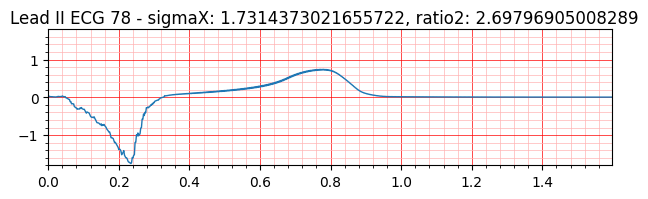

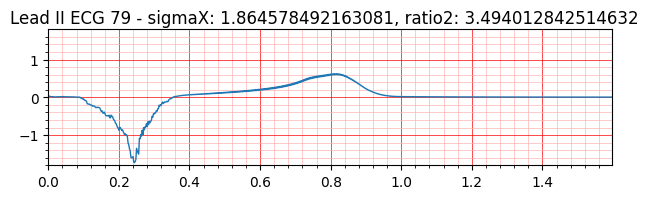

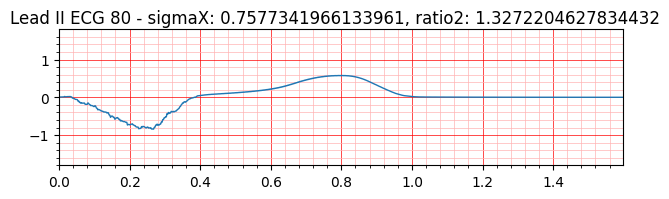

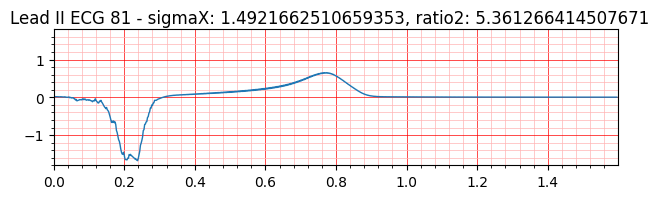

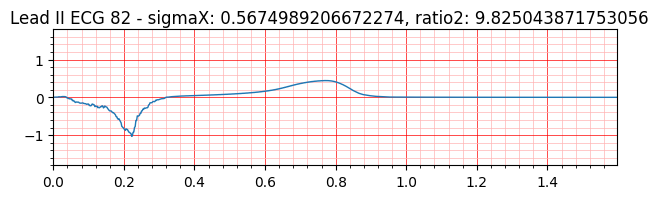

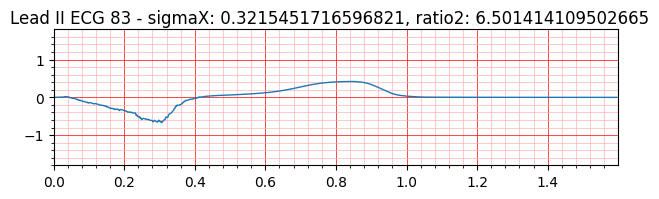

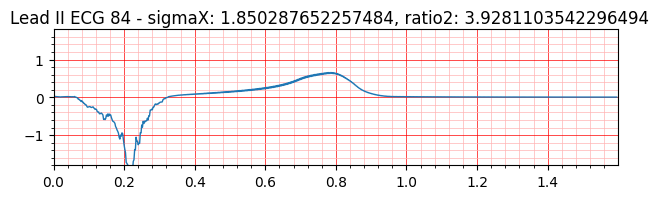

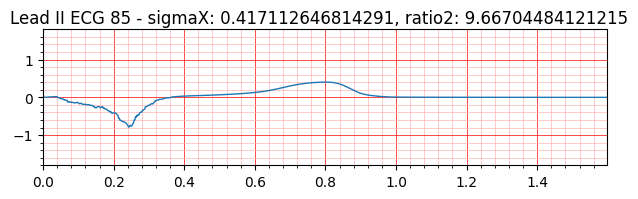

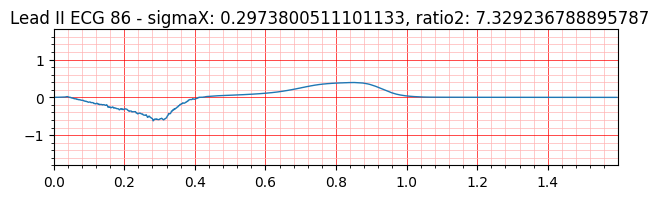

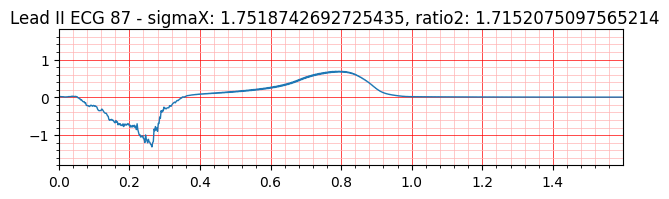

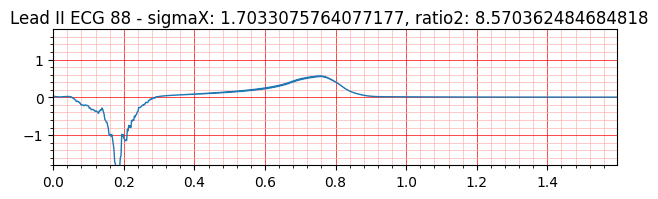

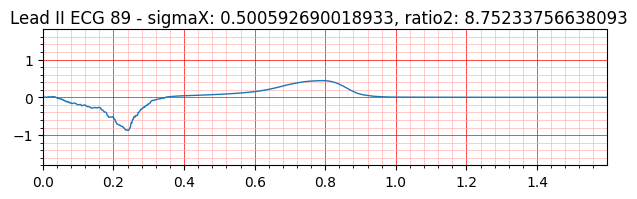

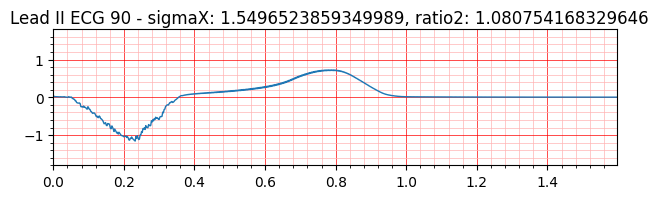

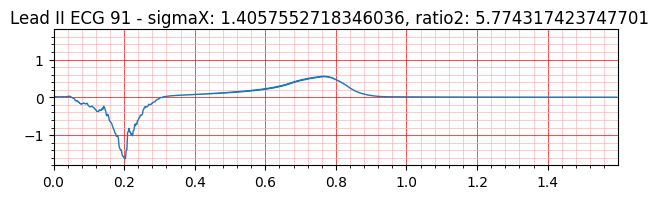

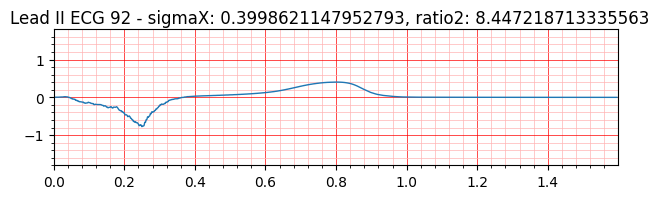

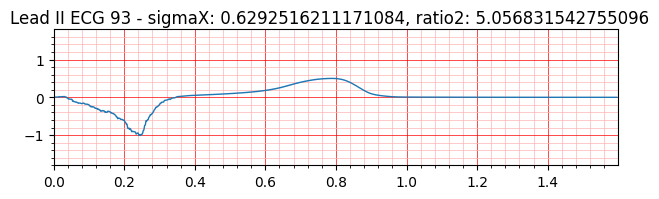

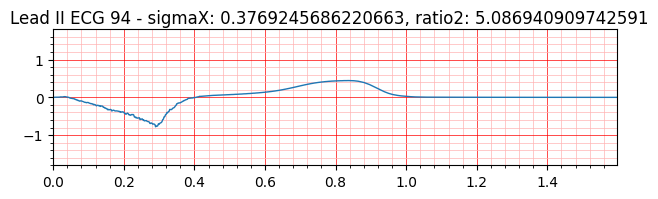

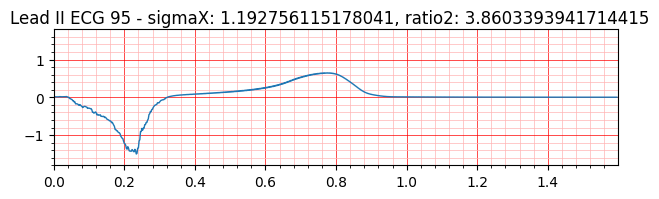

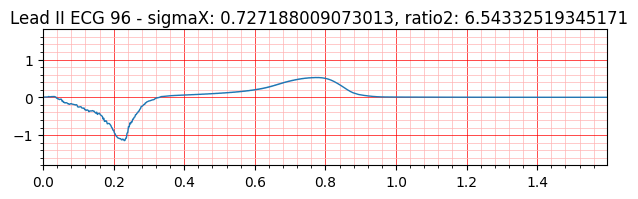

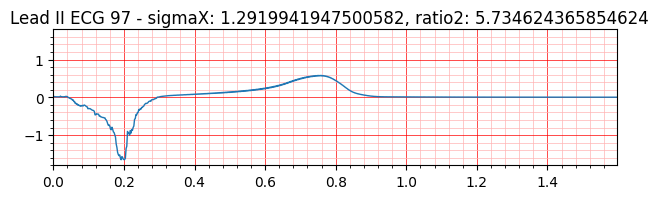

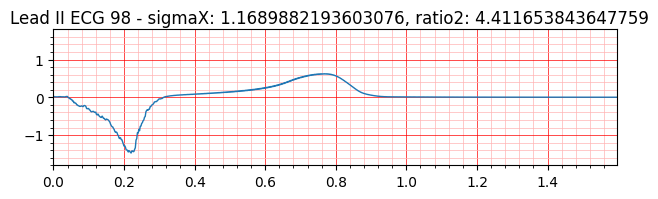

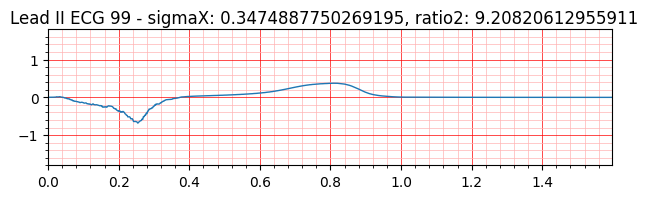

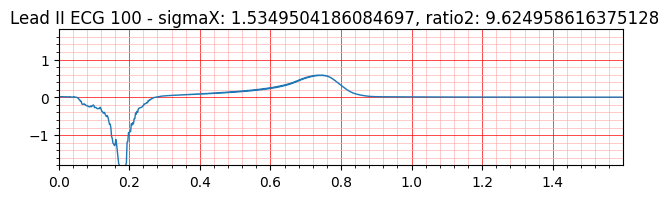

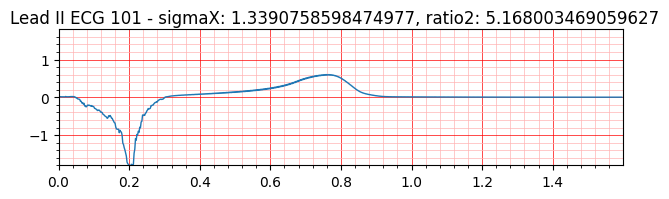

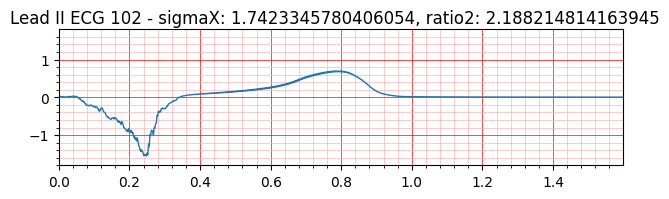

In [146]:
num_plots = 102  # the number of images displayed
for i in range(num_plots):
    plot_1(10*X[i], Y[i][0], Y[i][1], i)

In [9]:
filters = 64
kernel_size = 3
activation = 'relu'
optimizer = 'adam'
epochs = 10

In [10]:
import keras.backend as K

def mean_relative_error(y_true, y_pred):
    return K.mean(K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None)))

In [11]:
model = Sequential()


model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation=activation)) 
model.add(Dense(800))

model.compile(loss=mean_relative_error, 
              optimizer=optimizer, 
              metrics=[mean_relative_error])

ValueError: Exception encountered when calling layer "conv1d" (type Conv1D).

Negative dimension size caused by subtracting 3 from 2 for '{{node conv1d/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](conv1d/Conv1D/ExpandDims, conv1d/Conv1D/ExpandDims_1)' with input shapes: [?,1,2,1], [1,3,1,64].

Call arguments received by layer "conv1d" (type Conv1D):
  • inputs=tf.Tensor(shape=(None, 2, 1), dtype=float32)

In [105]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 797, 64)           256       
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 398, 64)           0         
 g1D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 25472)             0         
                                                                 
 dense_14 (Dense)            (None, 50)                1273650   
                                                                 
 dense_15 (Dense)            (None, 2)                 102       
                                                                 
Total params: 1274008 (4.86 MB)
Trainable params: 1274008 (4.86 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [133]:
history = model.fit(X, Y, epochs=500, validation_split=0.1)

Epoch 1/500
4/4 [==============================] - 1s 80ms/step - loss: 0.9038 - mean_relative_error: 0.8907 - val_loss: 0.6284 - val_mean_relative_error: 0.6284
Epoch 2/500
4/4 [==============================] - 0s 21ms/step - loss: 0.6537 - mean_relative_error: 0.6503 - val_loss: 0.5763 - val_mean_relative_error: 0.5763
Epoch 3/500
4/4 [==============================] - 0s 20ms/step - loss: 0.5676 - mean_relative_error: 0.5635 - val_loss: 0.4940 - val_mean_relative_error: 0.4940
Epoch 4/500
4/4 [==============================] - 0s 19ms/step - loss: 0.5067 - mean_relative_error: 0.5034 - val_loss: 0.4154 - val_mean_relative_error: 0.4154
Epoch 5/500
4/4 [==============================] - 0s 18ms/step - loss: 0.4467 - mean_relative_error: 0.4489 - val_loss: 0.4015 - val_mean_relative_error: 0.4015
Epoch 6/500
4/4 [==============================] - 0s 20ms/step - loss: 0.4056 - mean_relative_error: 0.4072 - val_loss: 0.4080 - val_mean_relative_error: 0.4080
Epoch 7/500
4/4 [===========

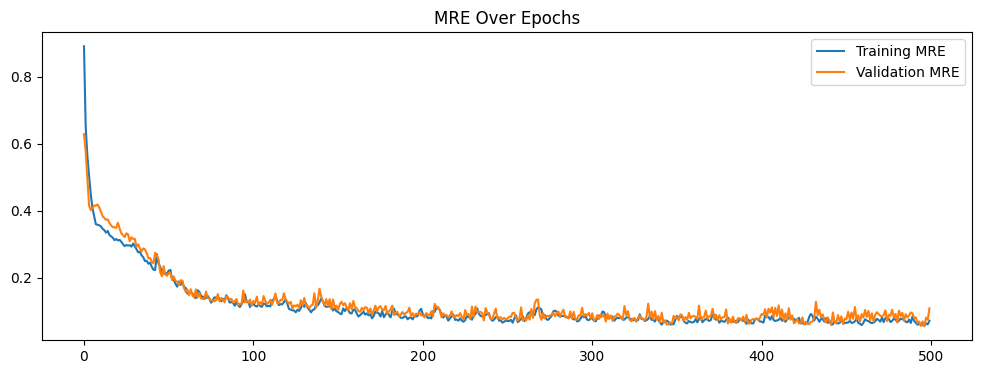

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(history.history['mean_relative_error'], label='Training MRE')
plt.plot(history.history['val_mean_relative_error'], label='Validation MRE')
plt.title('MRE Over Epochs')
plt.legend()

plt.show()

# validation error

In [135]:
test_loss, test_mre = model.evaluate(X, Y, verbose=2)
print("Test Loss:", test_loss)
print("Test MRE:", test_mre)

5/5 - 0s - loss: 0.0853 - mean_relative_error: 0.0983 - 39ms/epoch - 8ms/step
Test Loss: 0.08526778966188431
Test MRE: 0.0983215942978859


In [123]:
# history_data = history.history

# df_history = pd.DataFrame(history_data)

# df_mre = df_history[['mean_relative_error', 'val_mean_relative_error']]
# df_mre.to_csv(r'D:\xuhu\Temp\AI method\CNN_mre_history.csv', index=False)


In [124]:
def sample_mean_relative_error(y_true, y_pred):
    mre = np.abs((y_true - y_pred) / np.clip(np.abs(y_true), np.finfo(float).eps, None))
    # print(mre[0],mre[1])
    # print(len(mre))
    return mre[0]

In [141]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_test

array([[ 3.26861870e-03,  1.46829619e-03,  1.29950707e-03, ...,
         1.75538130e-04,  1.78982674e-04,  1.74484981e-04],
       [ 3.76362610e-03,  1.68999465e-03,  1.45425429e-03, ...,
         2.24324070e-04,  2.28647280e-04,  2.23263400e-04],
       [-4.66239920e-04, -3.93062890e-04, -6.07460000e-07, ...,
        -2.50759860e-04, -2.48686220e-04, -2.51347740e-04],
       ...,
       [ 1.26622683e-03,  5.50153980e-04,  6.74861790e-04, ...,
        -4.34041460e-05, -4.03783356e-05, -4.41278947e-05],
       [ 4.39182183e-05, -9.88883410e-05,  2.14565150e-04, ...,
        -1.70688693e-04, -1.68874311e-04, -1.71562994e-04],
       [ 2.19438237e-03,  1.00213160e-03,  9.89071400e-04, ...,
         5.40100620e-05,  5.84398700e-05,  5.32829640e-05]])

In [142]:
y_test

array([[1.20089313, 2.22713743],
       [1.31799678, 3.72625519],
       [0.317339  , 8.12840139],
       [0.91247952, 8.26767796],
       [0.45193543, 7.10342079],
       [0.51612953, 4.99616897],
       [1.6619951 , 4.20074448],
       [1.6660925 , 6.34374621],
       [0.56749892, 9.82504387],
       [1.34797435, 9.4234064 ],
       [0.72718801, 6.54332519],
       [0.43802692, 1.92598458],
       [0.94676142, 6.96522613]])

In [143]:
import pandas as pd
import numpy as np

mlp_predictions = model.predict(X_test)

mlp_mres = [sample_mean_relative_error(y_test[i], mlp_predictions[i]) for i in range(len(y_test))]

df_mlp_mre = pd.DataFrame(mlp_mres, columns=['MRE'])

df_mlp_mre.to_csv(r'D:\xuhu\Temp\AI method\cnn_mre_pred.csv', index=False)


1/1 [==============================] - 0s 28ms/step


# Worst Model

In [120]:
import numpy as np

train_mre = history.history['mean_relative_error']
val_mre = history.history['val_mean_relative_error']

worst_train_epoch = np.argmax(train_mre)
worst_val_epoch = np.argmax(val_mre)


print(f"Worst Training MRE: {train_mre[worst_train_epoch]} at epoch {worst_train_epoch + 1}")
print(f"Worst Validation MRE: {val_mre[worst_val_epoch]} at epoch {worst_val_epoch + 1}")

Worst Training MRE: 0.8962342739105225 at epoch 1
Worst Validation MRE: 0.6357729434967041 at epoch 1


In [93]:
from keras.callbacks import ModelCheckpoint

# save the model at the end of each epoch
checkpoint = ModelCheckpoint('Model/model_epoch_{epoch:02d}.hdf5', save_weights_only=True)

history = model.fit(X, Y, epochs=500, validation_split=0.1, callbacks=[checkpoint])


Epoch 1/500
4/4 [==============================] - 0s 28ms/step - loss: 0.0363 - mean_relative_error: 0.0361 - val_loss: 0.0481 - val_mean_relative_error: 0.0481
Epoch 2/500
4/4 [==============================] - 0s 27ms/step - loss: 0.0378 - mean_relative_error: 0.0378 - val_loss: 0.0501 - val_mean_relative_error: 0.0501
Epoch 3/500
4/4 [==============================] - 0s 26ms/step - loss: 0.0411 - mean_relative_error: 0.0414 - val_loss: 0.0525 - val_mean_relative_error: 0.0525
Epoch 4/500
4/4 [==============================] - 0s 26ms/step - loss: 0.0367 - mean_relative_error: 0.0370 - val_loss: 0.0468 - val_mean_relative_error: 0.0468
Epoch 5/500
4/4 [==============================] - 0s 25ms/step - loss: 0.0356 - mean_relative_error: 0.0354 - val_loss: 0.0494 - val_mean_relative_error: 0.0494
Epoch 6/500
4/4 [==============================] - 0s 38ms/step - loss: 0.0413 - mean_relative_error: 0.0414 - val_loss: 0.0575 - val_mean_relative_error: 0.0575
Epoch 7/500
4/4 [===========

In [102]:
model.load_weights('Model/model_epoch_211.hdf5')

# prediction: test error

In [113]:
# df = pd.read_csv(r'D:\xuhu\Temp\dataset_150_manual_clean.csv')
df_test = pd.read_csv(r"D:\xuhu\pyansys-heart\downloads\Strocchi2020\01\Biv_validation\dataset_40_220_val.csv")

print(df_test.head())

                                              LeadII    sigmaX    ratio2
0  [ 1.38304723e-03  6.03392600e-04  7.09771110e-...  0.754824  3.042172
1  [ 6.66718540e-04  2.38367460e-04  4.54364780e-...  0.585363  2.880405
2  [ 2.48670726e-03  1.12507994e-03  1.06806673e-...  1.015917  2.702048
3  [ 2.16360717e-03  9.91010740e-04  9.82529270e-...  0.939481  9.145591
4  [ 4.46819190e-03  1.99701173e-03  1.66662061e-...  1.484676  6.243965


In [118]:
# input
X_test = df_test['LeadII'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))
X_test = np.stack(X_test, axis=0)
# output: paramaters to predict
Y_test = df_test[['sigmaX', 'ratio2']].values

In [122]:
np.savetxt('val_Doe.csv', Y_test)

In [119]:
test_loss, test_mre = model.evaluate(X_test, Y_test, verbose=2)

2/2 - 0s - loss: 0.0625 - mean_relative_error: 0.0601 - 54ms/epoch - 27ms/step


## Test CNN performance with ROM worst-case 

In [20]:
import struct
import numpy as np

def read_binary(fn , debug = False):

    '''
    Reads a vector in ANSYS ROM Builder compatible binary format and returns the corresponding vector.
    '''

    fr = open(fn, "rb")
    nb = struct.unpack('Q', fr.read(8))[0]
    
    if debug:
        print("Read binary file containing " + str(nb) + " values.")
        
    vec = np.zeros(nb)
    
    for i in range(nb):
        vec[i] = struct.unpack('d', fr.read(8))[0]
        
    fr.close()
    
    return vec

In [147]:
import pandas as pd
import numpy as np

file_name = r'D:\xuhu\Temp\ROM_ECG_TRAIN_1601\roms\w_2501.bin'
# print(full_path)
ROM_result = read_binary(file_name)
ROM_result = np.expand_dims(ROM_result, axis=0)

In [148]:
X.shape

(129, 799)

In [149]:
ROM_result.shape

(1, 799)

In [150]:
ROM_Y = model.predict(ROM_result)
ROM_Y

1/1 [==============================] - 0s 49ms/step


array([[0.5572682, 6.614589 ]], dtype=float32)